# Collecting and Predicting Car Prices
***

### Table of Contents
1. [Introduction](#intro)
2. [Initial Import and Setup](#initial)
3. [Exploratory Data Analysis, Cleaning, and Standardization](#eda)
3. [Building Our Model and Making Predictions](#build_models)
4. [Conclusion](#Conclusion)

<a name="intro"></a>
# Introduction
As someone that takes the train to work everyday, I can't help but think about what car I might want to buy in the future. With that as inspiration, I built a web scraper to collect data about cars from a popular car selling website. While I won't go into detail about how I built my web scraper, it can be found on here[https://github.com/jbwebster/Data-Science-Portfolio/tree/master/Projects/CarPrices_Part1/cars_crawl.py]. This project is just as much or more about processing my own data as it is about actually building the machine learning model.

***

<a name="initial"></a>

# Initial Import and Setup

I begin here by simply importing some useful modules for the analysis, and loading the dataset. For convenience, I've displayed the first 7 rows of the dataset below. Prior to this, I have already removed duplicates from the scraped dataset and briefly checked to make sure the web scraper worked as expected.

In [106]:
import pandas as pd
from pandas import read_csv
from IPython.display import display # For displaying nicely dataframes
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler # Scale for PCA
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
import re
import warnings
import numpy as np
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('multi_combined.csv', sep=',',header=0) # Read csv into dataframe
display(data.head(7)) # Display the first 7 lines of the dataset

,Zipcode,Page,NewUsed,Year,Make,Model,MSRP,Dealer_Price,Fuel_Type,Exterior_Color,City_MPG,Interior_Color,Highway_MPG,Drivetrain,Transmission,Liters,V,Mileage,Customer_Review,URL
0,7097,1,USED,2016,INFINITI,Q70 3.7X,NaN,21495.0,Gasoline,Black,18.0,Graphite,24.0,AWD,7-Speed Automatic,3.7,6.0,27344.0,5.0,https://www.cars.com/vehicledetail/detail/8048...
1,7097,1,NEW,2020,Chevrolet,Trax LS,NaN,20056.0,Gasoline,Mosaic Black Metallic,26.0,Jet Black,31.0,AWD,6-Speed Automatic,1.4,6.0,0.0,4.6,https://www.cars.com/vehicledetail/detail/7999...
2,7097,1,USED,2016,Hyundai,Equus Signature,NaN,23900.0,Gasoline,Caspian Black,15.0,Black,23.0,RWD,8-Speed Automatic,5.0,8.0,26641.0,4.8,https://www.cars.com/vehicledetail/detail/7974...
3,7097,1,USED,2019,Cadillac,CT6 Luxury,NaN,36500.0,Gasoline,Crystal White Tri-Coat,NaN,NaN,NaN,AWD,10-Speed Automatic,3.6,6.0,3369.0,4.8,https://www.cars.com/vehicledetail/detail/7958...
4,7097,1,USED,2015,Maserati,Quattroporte S Q4,NaN,25995.0,Gasoline,Nero,15.0,Sabbia,24.0,AWD,8-Speed Automatic,3.0,6.0,36987.0,5.0,https://www.cars.com/vehicledetail/detail/8078...
5,7097,1,USED,2011,Chrysler,Town & Country Touring,NaN,4415.0,E85 Flex Fuel,White,17.0,NaN,25.0,FWD,Automatic,3.6,6.0,117007.0,4.8,https://www.cars.com/vehicledetail/detail/7828...
6,7097,1,NEW,2019,Kia,Niro LX,NaN,21475.0,Hybrid,Aurora Black,51.0,Charcoal,46.0,FWD,6-Speed Automatic with Auto-Shift,1.6,6.0,10.0,4.5,https://www.cars.com/vehicledetail/detail/7980...


As you can see above, our scraped data includes fairly general information about the vehicles, including New/Used, the year, make and model of the car, the dealer's asking price, the interior and exterior color of the car, city and highway MPG (miles per gallon), and some basic specs about the car such as the drivetrain, transmission type, engine size, the number of miles on the car, and the overall customer rating of the car (scale of 1-5). We have a pretty even mix of continuous and categorical data types.

***
<a name="eda"></a>

# Exploratory Data Analysis, Cleaning and Standardization

Before building our model, we'll take a look at our data and clean up any obvious problems we see.

Since the end goal of this project is to predict the Dealer_Price of a car, let's begin by simply checking how many cars are missing information about Dealer_Price.

In [3]:
na_count = len(data) - data[['Dealer_Price']].count(axis=0)
print("Number of cars missing Dealer_Price info: " + str(na_count))
print("Percent of dataset that is missing Dealer_Price info: " + str(na_count / len(data)))

Number of cars missing Dealer_Price info: Dealer_Price    131
dtype: int64
Percent of dataset that is missing Dealer_Price info: Dealer_Price    0.044152
dtype: float64


It appears that about 4% of our dataset does not have information about the price of the vehicle. Since our analysis will be centered around vehicle price, these rows in our dataset won't be very useful to us, so let's drop them. How many other missing values do we have?

In [38]:
# Drop cars with missing dealer prices
data_mod = data.dropna(subset=['Dealer_Price'])
# Drop columns we definitely don't need
data_mod = data_mod.drop(columns='Page')
data_mod = data_mod.drop(columns='URL')
data_mod = data_mod.drop(columns='MSRP')
# Count the number of other missing values
print("Number of Missing data values per column, given " + str(len(data_mod)) + " rows of remaining data.")
print(len(data_mod) - data_mod.count(axis=0))

Number of Missing data values per column, given 2836 rows of remaining data.
Zipcode              0
NewUsed              0
Year                 0
Make                 0
Model                0
Dealer_Price         0
Fuel_Type            0
Exterior_Color      36
City_MPG           352
Interior_Color     202
Highway_MPG        352
Drivetrain           1
Transmission        11
Liters             442
V                  448
Mileage            121
Customer_Review     77
dtype: int64


All cars are missing MSRP, so we can drop that column entirely. We see similar numbers of missing city vs highway MPG values and liters vs V values, so those likely have a lot of overlap. Before we decide how to address those values, let's get a better sense of the cars in our dataset.

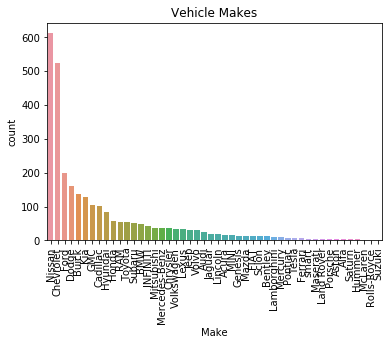

In [39]:
chart = sns.countplot(x="Make", data=data_mod,\
              order = data_mod['Make'].value_counts().index)

chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
chart.set_title("Vehicle Makes")
plt.show()

It appears that of our ~2800 cars, most of them are Nissan or Chevrolet. We should remove Makes that are under-represented in our dataset, as we won't be able to build a good model if we only have one or two cars from several of these brands. Let's limit ourselves to just the top 4 Makes: Nissan, Chevrolet, Ford and Dodge. Their cumulative total is over half of our dataset.

In [40]:
makes = ['Nissan', 'Chevrolet', 'Ford', 'Dodge']
data_make_drop = data_mod[data_mod.Make.str.contains('|'.join(makes))]
print(len(data_make_drop))

1498


Let's also take a look at our quantitative variables. Do they correlate well? Are there any obvious outliers?

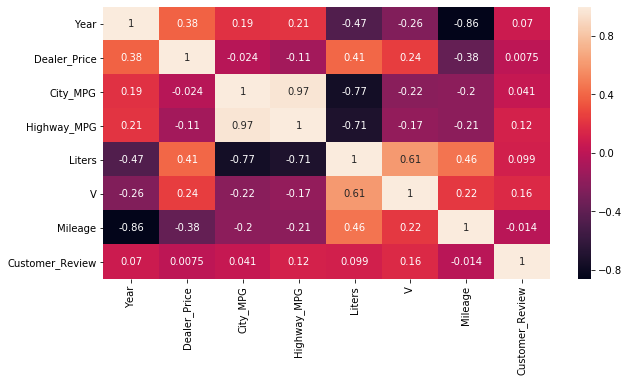

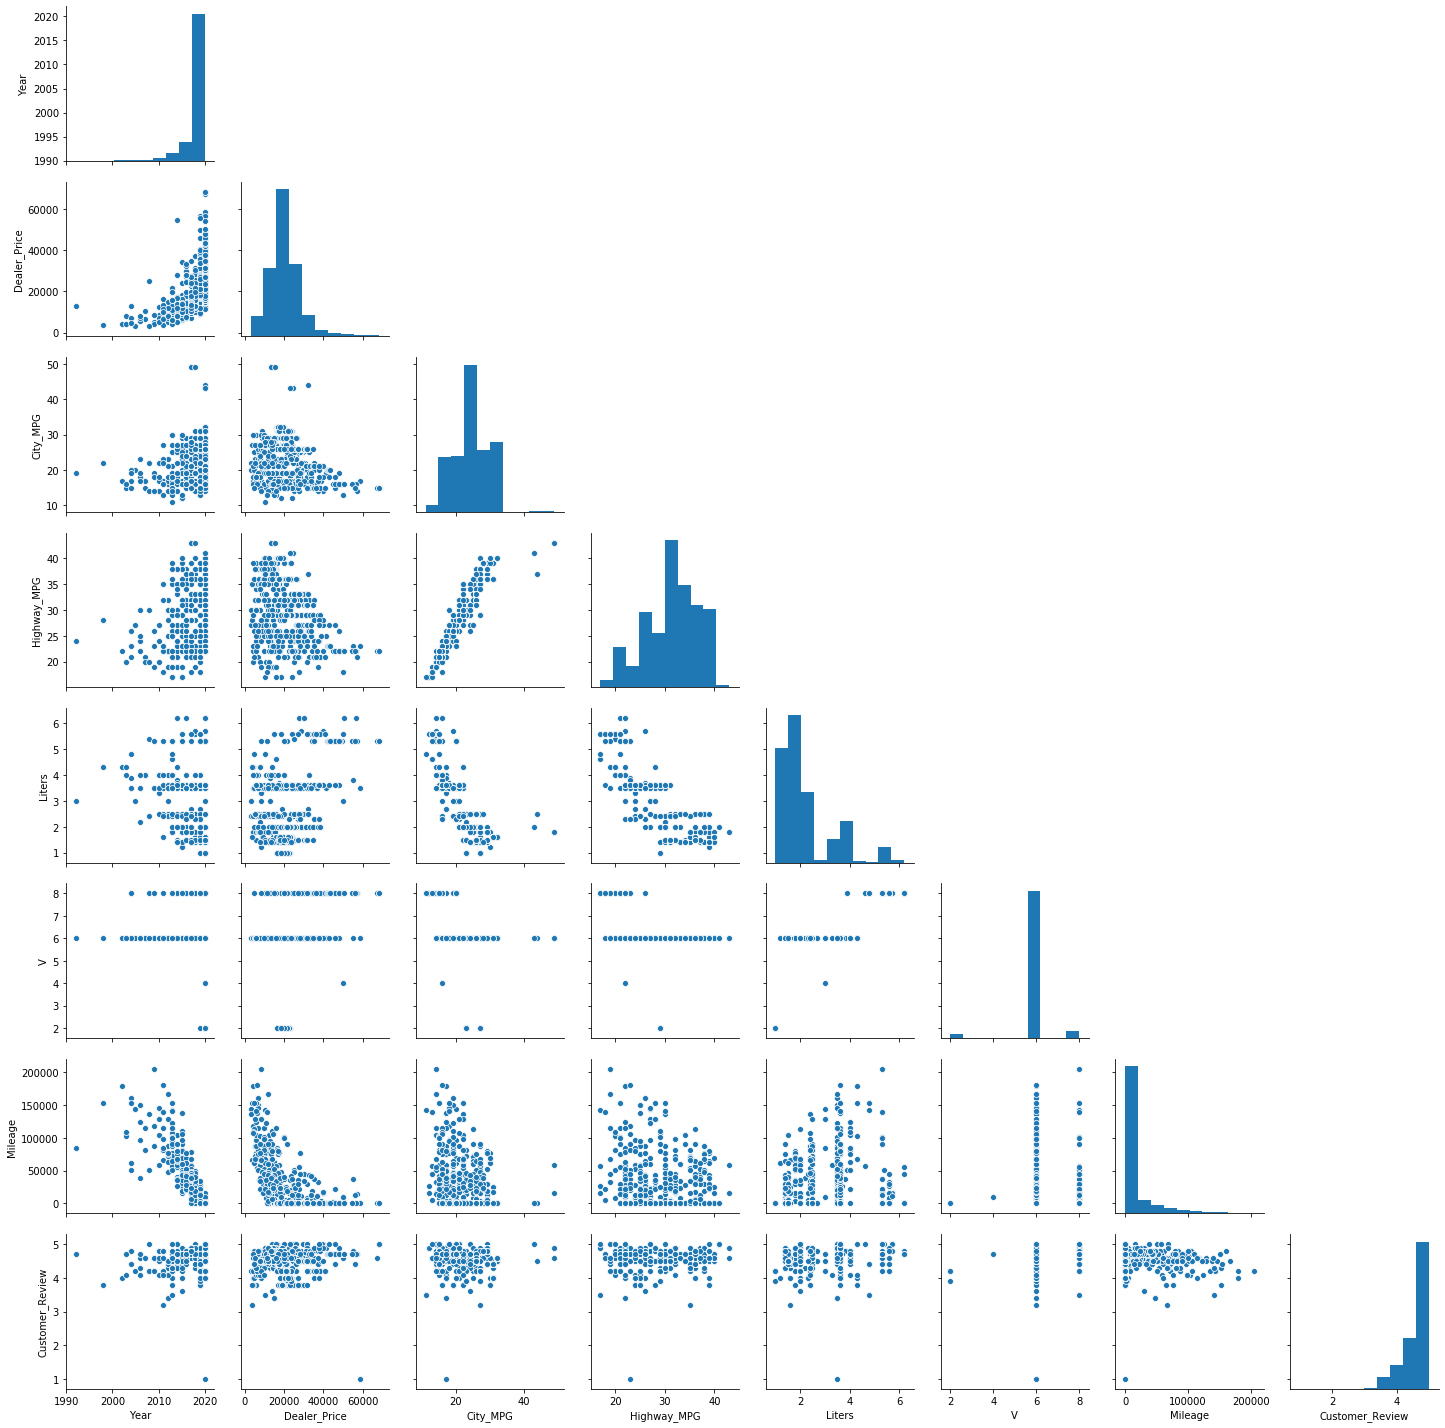

In [41]:
# Look at correlations between quantitative variables
data_quant = data_make_drop[['Year','Dealer_Price', 'City_MPG', 'Highway_MPG', 'Liters', 'V', 'Mileage', 'Customer_Review']]
plt.figure(figsize=(10,5))
c= data_quant.corr()
sns.heatmap(c,annot=True)

data_quant.describe()
data_quant_noNA = data_quant.dropna()

# SHOW BOTTOM TRIANGLE ONLY 
def hide_current_axis(*args, **kwds):
    plt.gca().set_visible(False)
    
g = sns.pairplot(data_quant_noNA)
g.map_upper(hide_current_axis);

There isn't anything too alarming here. We see the correlations we might expect: older cars have higher mileage, big engines get worse MPG, etc. One other important takeaway is that customer reviews don't seem to correlate well with anything. We might expect this, since the only people that review cars are typically people that liked the car enough to buy it in the first place (aside from our one outlier). We should be able to drop that column. 

While we're on the topic of quantitative variables, let's check how many missing values remain after implementing the changes we've done so far.

In [43]:
data_cr_drop = data_make_drop.drop(columns="Customer_Review")

# Count the number of other missing values
print("Number of Missing data values per column, given " + str(len(data_cr_drop)) + " rows of remaining data.")
print(len(data_cr_drop) - data_cr_drop.count(axis=0))

Number of Missing data values per column, given 1498 rows of remaining data.
Zipcode             0
NewUsed             0
Year                0
Make                0
Model               0
Dealer_Price        0
Fuel_Type           0
Exterior_Color     12
City_MPG          143
Interior_Color     99
Highway_MPG       143
Drivetrain          0
Transmission        8
Liters            230
V                 235
Mileage            90
dtype: int64


That removed about half of our missing values. Let's impute the quantitative values where possible by just using the median values for those columns. Other approaches exist and may be more optimal, but this should suit our purposes. For new cars, we'll just assume that the missing mileage would be 0.

In [44]:
data_im_q = data_cr_drop
data_im_q['City_MPG'] = data_im_q['City_MPG'].fillna((data_im_q['City_MPG'].median()))
data_im_q['Highway_MPG'] = data_im_q['Highway_MPG'].fillna((data_im_q['Highway_MPG'].median()))
data_im_q['Liters'] = data_im_q['Liters'].fillna((data_im_q['Liters'].median()))
data_im_q['V'] = data_im_q['Liters'].fillna((data_im_q['Liters'].median()))
data_im_q['Mileage'] = data_im_q['Mileage'].fillna((data_im_q['Mileage'].median()))
data_im_q.loc[data_im_q['NewUsed'].str.contains("New"), 'Mileage'] = 0

Now we'll need to address our qualitative variables a bit more. How many car models do we have?

In [45]:
print("Total number of vehicles: " + str(len(data_im_q)))
Model_counts = data_im_q['Model'].value_counts()
print(Model_counts)

Total number of vehicles: 1498
Trax LS                  154
Rogue SV                  86
Versa S                   69
Kicks SV                  65
Versa 1.6 SV              58
                        ... 
Spark EV 2LT               1
GT-R Black Edition         1
Sonic RS                   1
Express 1500 Work Van      1
Silverado 1500 RST         1
Name: Model, Length: 235, dtype: int64


It isn't necessarily ideal, but it looks like we have two options. Either we ignore the Model information, or we drop Models that appear infrequently in our data (most Models). Model information may be a pretty important variable - so I've chosen to only keep models that appear in our dataset more than 50 times. We won't be able to accurately predict the price of a limited edition sports model or other uncommon models anyway, so it's better that we focus on common cars with lots of data.

In [46]:
data_model_drop = data_im_q[data_im_q.groupby('Model').Model.transform(len)>50]
print(data_model_drop['Model'].value_counts())
print(data_model_drop['Make'].value_counts())
print("Number of Missing data values per column, given " + str(len(data_model_drop)) + " rows of remaining data.")
print(len(data_model_drop) - data_model_drop.count(axis=0))

Trax LS         154
Rogue SV         86
Versa S          69
Kicks SV         65
Versa 1.6 SV     58
Spark LS         55
Trax LT          52
Name: Model, dtype: int64
Nissan       278
Chevrolet    261
Name: Make, dtype: int64
Number of Missing data values per column, given 539 rows of remaining data.
Zipcode            0
NewUsed            0
Year               0
Make               0
Model              0
Dealer_Price       0
Fuel_Type          0
Exterior_Color     0
City_MPG           0
Interior_Color    19
Highway_MPG        0
Drivetrain         0
Transmission       1
Liters             0
V                  0
Mileage            0
dtype: int64


That leaves us with 7 Models, which seem to be split evenly between Nissan and Chevrolet (sorry Ford and Dodge, looks like we dropped you after all). The only missing values that remain are a few interior colors and 1 transmission value. We can address those when we look at those specific columns. 

Now that we've ensured that we have a decent amount of data for the cars we are looking at, and our quantitative data looks good, we need to standardize and clean our categorical data.

Let's start with our interior and exterior colors. We'll try to convert the color names into a smaller list of standard color names.

In [66]:
# Identify the base color of the custom name colors
root_colors = ['silver','white','black', 'red', \
               'gray','yellow','orange', 'blue', \
              'metallic', 'pearl', 'grey', 'granite', \
              'clearcoat', 'scarlet', 'graphite', \
              'green', 'emerald', 'crimson', 'brown', 'charcoal', 'beige', 'ebony']
pattern = '|'.join(root_colors)


def pattern_searcher(search_str:str, search_list:str, isExt:bool):
    if not isinstance(search_str, str):
        return None
    search_str = search_str.lower()
    search_obj = re.search(search_list, search_str)
    if search_obj :
        return_str = search_str[search_obj.start(): search_obj.end()]
        if return_str == "pearl":
            return_str = "white"
        elif return_str == "grey" or return_str == "granite":
            return_str = "gray"
        elif return_str == "clearcoat" or return_str == "graphite":
            return_str = "silver"
        elif return_str == "scarlet" or return_str == "crimson":
            return_str = "red"
        elif return_str == "emerald":
            return_str = "green"
        elif return_str == 'charcoal' or return_str == 'ebony':
            return_str = "black"
        elif return_str == 'beige':
            return_str = "brown"
        if isExt:
            return_str = "Ext_" + return_str
        else:
            return_str = "Int_" + return_str
        
        
    else:
        if isExt:
            return_str = "Ext_OTHER"
        else:
            return_str = 'Int_OTHER'
    return return_str


data_standard_colors = data_model_drop
n = len(data_standard_colors['Exterior_Color'].unique())
print("Number of unique exterior colors in original data: " + str(n))
data_standard_colors['Standard_Ext_Color'] = data_standard_colors['Exterior_Color'].apply(lambda x: pattern_searcher(search_str=x, search_list=pattern, isExt=True))
print("After standardization:")
print(data_standard_colors['Standard_Ext_Color'].value_counts())
n = len(data_standard_colors['Interior_Color'].unique())
print("Number of unique interior colors in original data: " + str(n))
data_standard_colors['Standard_Int_Color'] = data_standard_colors['Interior_Color'].apply(lambda x: pattern_searcher(search_str=x, search_list=pattern, isExt=False))
print(data_standard_colors['Standard_Int_Color'].value_counts())

# Drop the now unnecessary Exterior_Color and Interior_Color columns
data_standard_colors = data_standard_colors.drop(columns = ['Exterior_Color', 'Interior_Color'])

Number of unique exterior colors in original data: 52
After standardization:
Ext_black       137
Ext_white       127
Ext_silver       93
Ext_metallic     62
Ext_blue         39
Ext_red          34
Ext_gray         27
Ext_OTHER        12
Ext_orange        8
Name: Standard_Ext_Color, dtype: int64
Number of unique interior colors in original data: 10
Int_black     466
Int_silver     46
Int_brown       6
Int_gray        1
Int_OTHER       1
Name: Standard_Int_Color, dtype: int64


We've successfully converted the 52 listed exterior colors into 9 categories, and the 10 interior colors into 5 categories. 

What do the categories of our transmission, drivetrain, and fuel type data look like? Do we need to standardize them too?

In [67]:
print(data_standard_colors['Transmission'].value_counts())
print(data_standard_colors['Drivetrain'].value_counts())
print(data_standard_colors['Fuel_Type'].value_counts())

Automatic CVT        284
6-Speed Automatic    159
Automatic             81
5-Speed Manual         8
Variable               4
Manual                 2
Name: Transmission, dtype: int64
FWD    458
AWD     81
Name: Drivetrain, dtype: int64
Gasoline    539
Name: Fuel_Type, dtype: int64


For simplicity, let's just group these into "Automatic" vs "Manual" transmissions. We'll leave "Variable" as an option for now as well. Drivetrain data looks well standardized already, and since all values have "Gasoline" listed as a fuel type, we might as well just drop that column.

In [68]:
def transmission_pattern_searcher(search_str:str):
    if not isinstance(search_str, str):
        return None
    search_str = search_str.lower()
    search_obj = re.search("auto", search_str)
    if search_obj:
        tran_type = 'automatic'
    else:
        search_obj = re.search("variable", search_str)
        if search_obj:
            tran_type = "variable"
        else:
            tran_type = 'manual'
    return tran_type

# Transmission
data_trans = data_standard_colors
data_trans['Transmission_Type'] = data_trans['Transmission'].apply(lambda x: transmission_pattern_searcher(search_str=x))
data_trans = data_trans.drop(columns=['Transmission'])
# Drivetrain
data_trans.loc[data_trans.Drivetrain == "4x4", "Drivetrain"] = "4WD"
data_trans.loc[data_trans.Drivetrain == "4x2/2-wheel drive", "Drivetrain"] = "FWD"
data_trans.loc[data_trans.Drivetrain == "2WD", "Drivetrain"] = "FWD"
data_trans.loc[data_trans.Drivetrain == "4x4/4-wheel drive", "Drivetrain"] = "4WD"
# Drop fuel type
data_trans = data_trans.drop(columns="Fuel_Type")

We now should have no missing values, we've selected cars with a lot of supporting data, and we've standardized out categorical data. Common machine learning models expect numeric data as input though, so we need to convert some of our text columns into numbers. Just to remind ourselves what our data currently looks like, I've displayed it below.

In [69]:
display(data_trans)

,Zipcode,NewUsed,Year,Make,Model,Dealer_Price,City_MPG,Highway_MPG,Drivetrain,Liters,V,Mileage,Standard_Ext_Color,Standard_Int_Color,Transmission_Type
1,7097,NEW,2020,Chevrolet,Trax LS,20056.0,26.0,31.0,AWD,1.4,1.4,0.0,Ext_black,Int_black,automatic
16,7097,NEW,2020,Chevrolet,Trax LS,20056.0,26.0,31.0,AWD,1.4,1.4,0.0,Ext_gray,Int_black,automatic
84,7097,NEW,2020,Chevrolet,Trax LT,21749.0,26.0,31.0,AWD,1.4,1.4,0.0,Ext_white,Int_black,automatic
88,7097,NEW,2020,Nissan,Rogue SV,28676.0,26.0,33.0,AWD,2.5,2.5,6.0,Ext_silver,Int_black,automatic
94,7097,NEW,2020,Chevrolet,Trax LT,21749.0,26.0,31.0,AWD,1.4,1.4,0.0,Ext_gray,Int_black,automatic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2696,83701,NEW,2020,Nissan,Rogue SV,26986.0,26.0,33.0,AWD,2.5,2.5,22.0,Ext_metallic,Int_black,automatic
2736,83701,NEW,2020,Nissan,Rogue SV,27272.0,26.0,33.0,AWD,2.5,2.5,0.0,Ext_red,Int_black,automatic
2781,83701,NEW,2020,Chevrolet,Trax LS,16575.0,26.0,31.0,FWD,2.0,2.0,1.0,Ext_white,Int_black,automatic
2788,83701,NEW,2020,Nissan,Rogue SV,27772.0,26.0,33.0,AWD,2.5,2.5,0.0,Ext_red,Int_brown,automatic


With the above in mind, let's convert all of our non-numeric data into dummy variables and save our data.

In [72]:
## Zipcode dummy variables
# Get dummies
dummies = pd.get_dummies(data_trans['Zipcode'])
# Insert dummies
data_dum = pd.concat([data_trans, dummies], axis=1)
# Drop original and 1 dummy to avoid dummy trap
data_dum = data_dum.drop(['Zipcode', 7097], axis=1)
# Repeat the above for other categorical data
# New/Used dummy variables
dummies = pd.get_dummies(data_trans['NewUsed'])
data_dum = pd.concat([data_dum, dummies], axis=1)
data_dum = data_dum.drop(['NewUsed', 'NEW'], axis=1)
# Make
dummies = pd.get_dummies(data_trans['Make'])
data_dum = pd.concat([data_dum, dummies], axis=1)
data_dum = data_dum.drop(['Make', 'Chevrolet'], axis=1)
# Model
dummies = pd.get_dummies(data_trans['Model'])
data_dum = pd.concat([data_dum, dummies], axis=1)
data_dum = data_dum.drop(['Model', 'Trax LS'], axis=1)
# Drivetrain
dummies = pd.get_dummies(data_trans['Drivetrain'])
data_dum = pd.concat([data_dum, dummies], axis=1)
data_dum = data_dum.drop(['Drivetrain', 'AWD'], axis=1)
# Ext color
dummies = pd.get_dummies(data_trans['Standard_Ext_Color'])
data_dum = pd.concat([data_dum, dummies], axis=1)
data_dum = data_dum.drop(['Standard_Ext_Color', 'Ext_black'], axis=1)
# Int color
dummies = pd.get_dummies(data_trans['Standard_Int_Color'])
data_dum = pd.concat([data_dum, dummies], axis=1)
data_dum = data_dum.drop(['Standard_Int_Color', 'Int_black'], axis=1)
# Transmission type
dummies = pd.get_dummies(data_trans['Transmission_Type'])
data_dum = pd.concat([data_dum, dummies], axis=1)
data_dum = data_dum.drop(['Transmission_Type', 'automatic'], axis=1)
display(data_dum)
data_trans.to_csv("cleaned_car_data.csv", index=False, header=True)
data_dum.to_csv("cleaned_car_dummies.csv", index=False, header=True)

,Year,Dealer_Price,City_MPG,Highway_MPG,Liters,V,Mileage,33101,58001,63123,...,Ext_orange,Ext_red,Ext_silver,Ext_white,Int_OTHER,Int_brown,Int_gray,Int_silver,manual,variable
1,2020,20056.0,26.0,31.0,1.4,1.4,0.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16,2020,20056.0,26.0,31.0,1.4,1.4,0.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
84,2020,21749.0,26.0,31.0,1.4,1.4,0.0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
88,2020,28676.0,26.0,33.0,2.5,2.5,6.0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
94,2020,21749.0,26.0,31.0,1.4,1.4,0.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2696,2020,26986.0,26.0,33.0,2.5,2.5,22.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2736,2020,27272.0,26.0,33.0,2.5,2.5,0.0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2781,2020,16575.0,26.0,31.0,2.0,2.0,1.0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2788,2020,27772.0,26.0,33.0,2.5,2.5,0.0,0,0,0,...,0,1,0,0,0,1,0,0,0,0


<a name="build_models"></a>

# Building and Evaluating our Model

With our data cleaned and standardized, we're ready to try building a model! Here I've elected to simply try a variety of common potential models to see which one works the best on our dataset - *as the main component of this project is focused on data cleaning, I won't stress too much about the actual application of our model*. I've selected a few potential models for our use.

- Logistic Regression (LR)
- Linear Discriminant Analysis (LDA)
- K-Neighbors Regressor (KNR)

We'll start by loading our saved data, creating out training/validation cohorts, and evaluating our three potential models.

In [84]:
cleaned_data = read_csv("cleaned_car_dummies.csv")
array = cleaned_data.values
# Split data into training and validation datasets
independent = cleaned_data.drop('Dealer_Price', axis=1).values
dependent = cleaned_data['Dealer_Price'].values
print(len(cleaned_data))

539


In [116]:
X_train, X_validation, Y_train, Y_validation = train_test_split(independent, dependent, test_size=0.25, random_state=1, shuffle=True)
# Create list of algorithms to try
models = []
models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNR', KNeighborsRegressor(algorithm='brute')))
# Evaluate each model
results = []
names = []
print("Name: Score (Standard Dev)")
for name, model in models:
    kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold)
    #results.append(cv_results)
    names.append(name)
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

Name: Score (Standard Dev)
LR: 0.379829 (0.048559)
LDA: 0.261466 (0.089955)
KNR: 0.826935 (0.079450)


Based on the above, it appears that the the *K-Neighbor Regressor algorithm had the highest accuracy*. We can now take our best performing model, train it, and start making predictions! 

Text(0.5, 0, 'Actual Price')

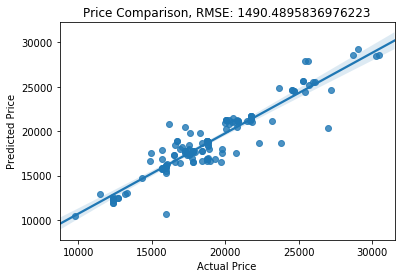

In [135]:
# Build model and make predictions
model = KNeighborsRegressor(algorithm='brute')
model.fit(X_train, Y_train)
predictions = model.predict(X_validation)
rmse = mean_squared_error(Y_validation, predictions) ** (1/2)
d = {'Predicted_Price': predictions, 'Actual_Price': Y_validation}
out_df = pd.DataFrame(d)
ax = sns.regplot(x=out_df["Actual_Price"], y=out_df["Predicted_Price"])
ax.set_title("Price Comparison, RMSE: " + str(rmse))
ax.set_ylabel("Predicted Price")
ax.set_xlabel("Actual Price")

That doesn't look too bad, considering our relatively low sample size and the variability that exists in the car market. It's possible that cars that have an asking price much lower than our predicted price are either a great deal or have something wrong with them (or our model just isn't that great), but those vehicles could definitely be worth checking out if you're in the market for a car.
***

<a name="Conclusion"></a>
# Conclusion

We effectively managed to build a web scraper to scrape data on over 2,800 cars from a popular car website. We were then able to clean and standardize our scraped data, honing in on the Makes and Models that appeared most frequently in our dataset and simplifying some of the categorical data. We introduced dummy variables into our dataset and we then briefly evaluated three different models on a subset of our data and applied the best fitting algorithm, the K-Neighbors Regressor algorithm, to our validation cohort, achieving a relatively decent model. A model like this could be used in a number of ways: a dealership could use something similar to get an idea of what they should be asking for a car, or someone looking to buy a car might be able to identify cars for sale that are being sold for less than normal.